# Mosaic Evolution Analysis

This notebook analyzes exported individuals from the Mosaic evolutionary algorithm.

## Features
1. **Fitness over time** - Track evolutionary progress
2. **Individual comparison** - Compare best individuals side-by-side
3. **Icon inspector** - Examine specific pieces and their properties

In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from pathlib import Path
from PIL import Image

# Notebook settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Load Data
We expect the NDJSON to conform to the schema in `doc/individual_export_schema.json`.

In [ ]:
def load_ndjson(filepath):
    """Load all individuals from NDJSON file"""
    individuals = []
    with open(filepath, 'r') as f:
        for line in f:
            individuals.append(json.loads(line))
    return individuals

# Load your export file
ndjson_file = '../best-individual.ndjson'  # Path to your NDJSON file
individuals = load_ndjson(ndjson_file)

print(f"Loaded {len(individuals)} individuals")
print(f"Generations: {min(ind['generation'] for ind in individuals)} - {max(ind['generation'] for ind in individuals)}")
print(f"Fitness range: {min(ind['fitness'] for ind in individuals):.2f} - {max(ind['fitness'] for ind in individuals):.2f}")

Loaded 1 individuals
Generations: 997 - 997
Fitness range: 57.80 - 57.80


## 2. Fitness Over Time

Visualize how fitness improves over generations.

In [ ]:
def plot_fitness_over_time(individuals):
    """Plot fitness progression over generations"""
    generations = [ind['generation'] for ind in individuals]
    fitnesses = [ind['fitness'] for ind in individuals]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Fitness over time
    ax1.plot(generations, fitnesses, marker='o', linestyle='-', linewidth=2, markersize=6)
    ax1.set_xlabel('Generation', fontsize=12)
    ax1.set_ylabel('Fitness (lower is better)', fontsize=12)
    ax1.set_title('Fitness Evolution Over Time', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add improvement rate annotation
    if len(fitnesses) > 1:
        initial_fitness = fitnesses[0]
        final_fitness = fitnesses[-1]
        improvement = ((initial_fitness - final_fitness) / initial_fitness) * 100
        ax1.text(0.05, 0.95, f'Improvement: {improvement:.1f}%', 
                transform=ax1.transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Improvement rate (delta between consecutive generations)
    if len(fitnesses) > 1:
        deltas = [fitnesses[i] - fitnesses[i-1] for i in range(1, len(fitnesses))]
        ax2.bar(generations[1:], deltas, color=['green' if d < 0 else 'red' for d in deltas], alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.set_xlabel('Generation', fontsize=12)
        ax2.set_ylabel('Fitness Change', fontsize=12)
        ax2.set_title('Generation-to-Generation Change (green=improvement)', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

plot_fitness_over_time(individuals)

# Visualize Single Individual

In [ ]:
def show_individual(individual):
    """
    Display all pages of an individual horizontally, like Individual.show() in C++.
    Shows actual icon images if available, otherwise shows main color.
    """
    num_pages = len(individual['pages'])
    
    # Create figure with all pages side by side
    fig, axes = plt.subplots(1, num_pages, figsize=(4*num_pages, 6))
    
    # Handle single page case
    if num_pages == 1:
        axes = [axes]
    
    # Set figure title with individual info
    fig.suptitle(
        f"Individual - Generation {individual['generation']}, "
        f"Fitness: {individual['fitness']:.2f}, "
        f"Piece Type: {individual['piece_type']}",
        fontsize=14, 
        fontweight='bold',
        y=0.98
    )
    
    # Draw each page
    for page_idx, page in enumerate(individual['pages']):
        ax = axes[page_idx]


NameError: name 'best_individual' is not defined

In [ ]:
        
        # Get page dimensions
        rows, cols = 6, 4
        
        # Create a composite image for the page
        # Assume icons are roughly square, allocate 100px per cell
        cell_size = 100
        page_img = np.zeros((rows * cell_size, cols * cell_size, 3))
        
        # Fill in pieces
        for piece in page['pieces']:
            row = piece['row']
            col = piece['column']
            
            # Calculate pixel coordinates
            y_start = row * cell_size
            y_end = (row + 1) * cell_size
            x_start = col * cell_size
            x_end = (col + 1) * cell_size
            
            # Try to load icon image
            if 'icon_path' in piece and piece['icon_path']:
                icon_path = Path(piece['icon_path'])
                if icon_path.exists():
                    try:
                        # Load and resize icon to fit cell
                        img = Image.open(icon_path)
                        img = img.resize((cell_size, cell_size), Image.Resampling.LANCZOS)
                        img_array = np.array(img)
                        
                        # Handle different image formats
                        if img_array.ndim == 2:  # Grayscale
                            img_array = np.stack([img_array] * 3, axis=-1)
                        elif img_array.shape[2] == 4:  # RGBA
                            # Convert RGBA to RGB by blending with white background
                            alpha = img_array[:, :, 3:4] / 255.0
                            rgb = img_array[:, :, :3]
                            img_array = (rgb * alpha + 255 * (1 - alpha)).astype(np.uint8)
                        
                        # Normalize to 0-1 range
                        page_img[y_start:y_end, x_start:x_end] = img_array / 255.0
                    except Exception as e:
                        # If loading fails, fall back to main color
                        print(f"Warning: Failed to load {icon_path}: {e}")
                        color = np.array(piece['main_color']).reshape(1, 1, 3)
                        page_img[y_start:y_end, x_start:x_end] = color
                else:
                    # Icon path doesn't exist, use main color
                    color = np.array(piece['main_color']).reshape(1, 1, 3)
                    page_img[y_start:y_end, x_start:x_end] = color
            else:
                # No icon path, use main color
                color = np.array(piece['main_color']).reshape(1, 1, 3)
                page_img[y_start:y_end, x_start:x_end] = color
        
        # Display page
        ax.imshow(page_img, interpolation='nearest')
        ax.set_title(
            f"Page {page_idx}\n"
            f"{len(page['pieces'])} pieces | "
            f"Distance: {page['total_distances']:.1f} | "
            f"Variance: {page['variance']:.1f}",
            fontsize=10
        )
        
        # Add grid lines at cell boundaries
        for i in range(1, rows):
            ax.axhline(y=i*cell_size - 0.5, color='white', linewidth=2)
        for i in range(1, cols):
            ax.axvline(x=i*cell_size - 0.5, color='white', linewidth=2)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"\n{'INDIVIDUAL SUMMARY':-^60}")
    print(f"Fitness: {individual['fitness']:.4f}")
    print(f"Generation: {individual['generation']}")
    print(f"Total pieces: {sum(len(p['pieces']) for p in individual['pages'])}")
    print(f"Number of pages: {num_pages}")
    print(f"Piece type: {individual['piece_type']}")
    print(f"\n{'PAGE BREAKDOWN':-^60}")
    for i, page in enumerate(individual['pages']):
        print(f"Page {i}: {len(page['pieces'])} pieces, "
              f"distance={page['total_distances']:.2f}, "
              f"variance={page['variance']:.2f}, "
              f"missing={page['icons_missing']}")

# Show the best individual
show_individual(best_individual)

## 3. Individual Comparison

Compare multiple individuals side-by-side to see if best individuals converge to similar solutions.

In [ ]:
def visualize_page_grid(page, ax, title=""):
    """Visualize a single page as a color grid"""
    height = page['pieces'][0]['row'] + 1 if page['pieces'] else 6  # Default 6 rows
    width = 4  # iOS standard
    
    # Initialize grid with black (empty)
    grid = np.zeros((6, 4, 3))
    
    # Fill in pieces
    for piece in page['pieces']:
        row = piece['row']
        col = piece['column']
        color = piece['main_color']
        grid[row, col] = color
    
    ax.imshow(grid, interpolation='nearest')
    ax.set_title(f"{title}\nDistance: {page['total_distances']:.2f}, Variance: {page['variance']:.2f}", 
                fontsize=10)
    ax.set_xticks(range(4))
    ax.set_yticks(range(6))
    ax.grid(True, color='white', linewidth=2)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def compare_individuals(individuals, indices=None):
    """Compare multiple individuals side-by-side"""
    if indices is None:
        # Default: compare first, middle, and last
        indices = [0, len(individuals)//2, len(individuals)-1]
    
    selected = [individuals[i] for i in indices]
    
    for ind in selected:
        num_pages = len(ind['pages'])
        fig, axes = plt.subplots(1, num_pages, figsize=(4*num_pages, 6))
        
        if num_pages == 1:
            axes = [axes]
        
        fig.suptitle(f"Individual - Generation {ind['generation']}, Fitness: {ind['fitness']:.2f}", 
                    fontsize=14, fontweight='bold')
        
        for i, page in enumerate(ind['pages']):
            visualize_page_grid(page, axes[i], title=f"Page {i}")
        
        plt.tight_layout()
        plt.show()

# Compare best, middle, and worst individuals
if len(individuals) >= 3:
    compare_individuals(individuals, indices=[0, len(individuals)//2, -1])
else:
    compare_individuals(individuals)

## 4. Icon Property Inspector

Examine specific pieces to see their color clusters and neighbor relationships.


PIECE INSPECTION - Page 0, Position 0

Location: Row 0, Column 0
Genome Index: 0
Icon: icon_604.png

Main Color (BGR): [0.16689223051071167, 0.16385400295257568, 0.19090065360069275]
Avg Neighbor Distance: 0.1469

-----------------------Color Clusters-----------------------
  Cluster 1: RGB(0.139, 0.139, 0.148) - Weight: 0.923
  Cluster 2: RGB(0.495, 0.465, 0.702) - Weight: 0.077

-------------------------Neighbors--------------------------
  E  : distance=0.1780, weight=1.000, weighted=0.1780
  S  : distance=0.1159, weight=1.000, weighted=0.1159


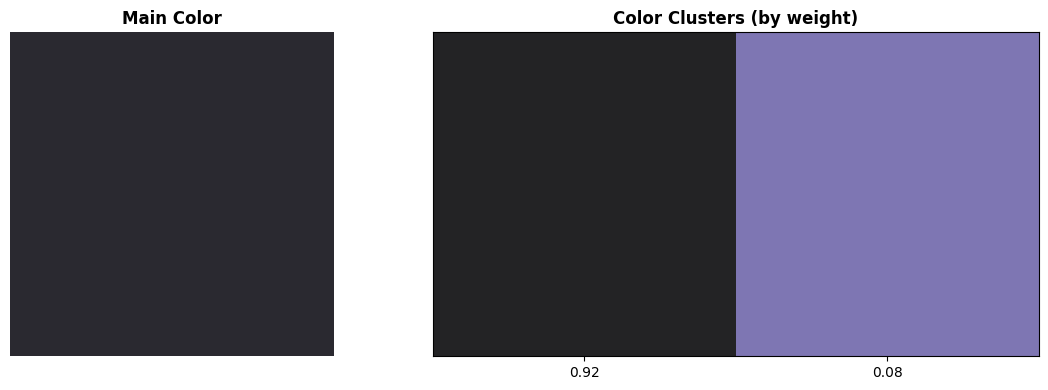

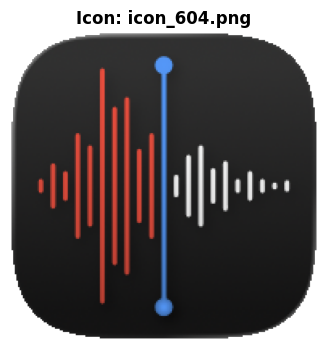

In [3]:
def inspect_piece(individual, page_idx, piece_idx):
    """Inspect a specific piece's properties"""
    page = individual['pages'][page_idx]
    piece = page['pieces'][piece_idx]
    
    print(f"\n{'='*60}")
    print(f"PIECE INSPECTION - Page {page_idx}, Position {piece_idx}")
    print(f"{'='*60}\n")
    
    print(f"Location: Row {piece['row']}, Column {piece['column']}")
    print(f"Genome Index: {piece['genome_index']}")
    
    if 'icon_path' in piece:
        print(f"Icon: {Path(piece['icon_path']).name}")
    
    print(f"\nMain Color (BGR): {piece['main_color']}")
    print(f"Avg Neighbor Distance: {piece['avg_neighbor_distance']:.4f}")
    
    print(f"\n{'Color Clusters':-^60}")
    for i, qc in enumerate(piece['quantified_colors']):
        color = qc['color']
        weight = qc['weight']
        print(f"  Cluster {i+1}: RGB({color[0]:.3f}, {color[1]:.3f}, {color[2]:.3f}) - Weight: {weight:.3f}")
    
    print(f"\n{'Neighbors':-^60}")
    for neighbor in piece['neighbors']:
        print(f"  {neighbor['direction']:3s}: "
              f"distance={neighbor['distance']:.4f}, "
              f"weight={neighbor['weight']:.3f}, "
              f"weighted={neighbor['weighted_distance']:.4f}")
    
    # Visualize color clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Main color
    main_color = np.array(piece['main_color']).reshape(1, 1, 3)
    ax1.imshow(main_color)
    ax1.set_title('Main Color', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Color clusters
    clusters = [qc['color'] for qc in piece['quantified_colors']]
    cluster_grid = np.array(clusters).reshape(1, len(clusters), 3)
    ax2.imshow(cluster_grid, interpolation='nearest', aspect='auto')
    ax2.set_title('Color Clusters (by weight)', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(len(clusters)))
    ax2.set_xticklabels([f"{qc['weight']:.2f}" for qc in piece['quantified_colors']])
    ax2.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Show icon if path exists
    if 'icon_path' in piece:
        icon_path = piece['icon_path']
        if Path(icon_path).exists():
            img = Image.open(icon_path)
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.title(f"Icon: {Path(icon_path).name}", fontsize=12, fontweight='bold')
            plt.axis('off')
            plt.show()

# Example: Inspect the first piece on the first page of the best individual
best_individual = individuals[0]  # Assuming sorted by fitness
inspect_piece(best_individual, page_idx=0, piece_idx=0)

## 5. Find Problematic Pieces

Identify pieces with high neighbor distances (potential problem areas).

In [1]:
def find_problematic_pieces(individual, threshold=0.8):
    """Find pieces with high average neighbor distance"""
    problematic = []
    
    for page_idx, page in enumerate(individual['pages']):
        for piece in page['pieces']:
            if piece['avg_neighbor_distance'] > threshold:
                problematic.append({
                    'page': page_idx,
                    'position': piece['page_position'],
                    'genome_index': piece['genome_index'],
                    'avg_distance': piece['avg_neighbor_distance'],
                    'icon_path': piece.get('icon_path', 'N/A')
                })
    
    # Sort by distance (worst first)
    problematic.sort(key=lambda x: x['avg_distance'], reverse=True)
    
    print(f"\nFound {len(problematic)} pieces with avg_neighbor_distance > {threshold}:\n")
    for i, p in enumerate(problematic[:10]):  # Show top 10
        icon_name = Path(p['icon_path']).name if p['icon_path'] != 'N/A' else 'N/A'
        print(f"{i+1}. Page {p['page']}, Pos {p['position']}: "
              f"distance={p['avg_distance']:.4f} - {icon_name}")
    
    return problematic

# Find problematic pieces in best individual
problematic = find_problematic_pieces(best_individual, threshold=0.7)

# Inspect the worst piece
if problematic:
    worst = problematic[2]
    print(f"\n\nInspecting worst piece (Page {worst['page']}, Position {worst['position']}):\n")
    inspect_piece(best_individual, worst['page'], worst['position'])

NameError: name 'best_individual' is not defined

## 6. Interactive Piece Selection

Select any piece by page and position to inspect.

In [ ]:
# Change these to inspect different pieces
PAGE_INDEX = 0
PIECE_INDEX = 5

inspect_piece(best_individual, PAGE_INDEX, PIECE_INDEX)